In [1]:
%run ../initialize.ipynb

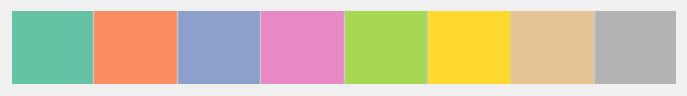

In [2]:
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Global functions

In [3]:
def get_window(window_type, n, partition_cols, date_orderby_col):
    '''accepts window type (days, games, seasons),
     size of window n,
     and window fields (partition and sort), 
     and returns a spark Window'''
    assert type(partition_cols) is list
    assert type(date_orderby_col) is str
    assert type(n) is int
    assert window_type in ['games','days','seasons']
    
    from pyspark.sql.window import Window
    if window_type == 'games':
        ## fixed number of games
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).desc())\
                  .rowsBetween(1, n)

    elif window_type == 'days':
        ## fixed number of days
        seconds = 24*60*60*n
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

    elif window_type == 'seasons':
        ## fixed number of seasons, including current
        ## n = 1 is YTD
        seconds = 24*60*60*(180 + 365*(n-1))
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

## Travel Features
* key: (game_id)
* table name: features.matchup

In [4]:
key = 'game_id'
out_tbl = 'features.travel'
features_list = []

In [16]:
game = spark.table('game').select('game_id','season','date','stadium','h_team_id',
                                  'v_team_id','is_neutral')
stadium = spark.table('stadium').select('stadium','season','lat','long','timezone',
                                        'stadium_home_team')
game_tines = spark.table('game_metadata').select('game_id','game_time_eastern',
                                                 'game_time_local')

game_stad = game.join(stadium, on=['stadium','season'])\
                .join(game_tines, on=['game_id'])

game_stad.limit(5).toPandas()

,game_id,stadium,season,date,h_team_id,v_team_id,is_neutral,lat,long,timezone,stadium_home_team,game_time_eastern,game_time_local
0,201511150ram,Edward Jones Dome,2015,2015-11-15,ram,chi,0,38.63278,-90.18861,-6.0,['ram'],13.0,12.0
1,201511090sdg,Qualcomm Stadium,2015,2015-11-09,sdg,chi,0,32.78306,-117.11944,-8.0,['sdg'],21.0,18.0
2,201510180det,Ford Field,2015,2015-10-18,det,chi,0,42.34000,-83.04556,-5.0,['det'],13.0,13.0
3,201512270tam,Raymond James Stadium,2015,2015-12-27,tam,chi,0,27.97583,-82.50333,-5.0,['tam'],13.0,13.0
4,201510110kan,Arrowhead Stadium,2015,2015-10-11,kan,chi,0,39.04889,-94.48389,-6.0,['kan'],13.0,12.0


In [17]:
## join in with visitor's lat/long and timezone
visitor_home = game_stad.withColumn(
    'tmp', 
    ## python udf to convert string list to Spark Array
    udf(lambda x: eval(x), ArrayType(StringType()))('stadium_home_team')
).select(
    'stadium','season',
    col('lat').alias('v_lat'),
    col('long').alias('v_long'),
    col('timezone').alias('v_timezone'),
    F.explode('tmp').alias('v_team_id')
)

## dups exist, e.g. Bills play games in Toronto and I considered that
## their home stadium, so they have 2 home stadiums some season
visitor_home.groupby('v_team_id','season')\
    .agg(F.countDistinct('stadium').alias('count'))\
    .filter(col('count') > 1)\
    .toPandas()

visitor_count = visitor_home.groupby('v_team_id','season','stadium')\
                    .count()

visitor_max = visitor_count.groupby('v_team_id','season')\
                         .agg(F.max('count').alias('count'))

visitor_uniq = visitor_count.join(
    visitor_max, on=['v_team_id','season','count']
).drop('count')

assert visitor_uniq.groupby('v_team_id','season').count()\
        .toPandas()['count'].max() == 1

,v_team_id,season,count
0,buf,2009,2
1,buf,2013,2
2,min,2010,2
3,buf,2010,2
4,buf,2012,2
5,buf,2011,2
6,buf,2008,2


In [18]:
v_stad_info = visitor_uniq.join(
    spark.table('stadium').select(
        'stadium',
        'season',
        col('lat').alias('v_lat'),
        col('long').alias('v_long'),
        col('timezone').alias('v_tz'),
    ), on=['stadium','season']
).drop('stadium')

v_stad_info.limit(5).toPandas()

,season,v_team_id,v_lat,v_long,v_tz
0,2013,dal,32.74778,-97.09278,-6.0
1,2009,nyj,40.81222,-74.07694,-5.0
2,2013,sdg,32.78306,-117.11944,-8.0
3,2016,crd,33.52750,-112.26250,-7.0
4,2008,crd,33.52750,-112.26250,-7.0


In [21]:
game_stad_info = game_stad.select(
    'game_id','season','date','h_team_id','v_team_id','is_neutral',
    'game_time_eastern','game_time_local',
    col('lat').alias('h_lat'),
    col('long').alias('h_long'),
    col('timezone').alias('h_tz')
).join(
    v_stad_info, on=['v_team_id','season']
).select(
    'game_id','season','date','is_neutral','h_team_id','v_team_id',
    'h_lat', 'h_long', 'h_tz', 'v_lat','v_long','v_tz',
    'game_time_eastern','game_time_local'
)

In [22]:
game_stad_info.limit(5).toPandas()

,game_id,season,date,is_neutral,h_team_id,v_team_id,h_lat,h_long,h_tz,v_lat,v_long,v_tz,game_time_eastern,game_time_local
0,201109250buf,2011,2011-09-25,0,buf,nwe,42.77400,-78.78700,-5.0,42.090944,-71.264344,-5.0,13.0,13.0
1,201112110was,2011,2011-12-11,0,was,nwe,38.90778,-76.86444,-5.0,42.090944,-71.264344,-5.0,13.0,13.0
2,201110300pit,2011,2011-10-30,0,pit,nwe,40.44667,-80.01583,-5.0,42.090944,-71.264344,-5.0,16.0,16.0
3,201111270phi,2011,2011-11-27,0,phi,nwe,39.90083,-75.16750,-5.0,42.090944,-71.264344,-5.0,16.0,16.0
4,201109120mia,2011,2011-09-12,0,mia,nwe,25.95806,-80.23889,-5.0,42.090944,-71.264344,-5.0,19.0,19.0


### Travel from last game

### Distance from home stadium

### Body clock time
* visiting team's body clock
* game in last week's time for visiting team
* home team's game time last week

### Travel last 3, 5 games

### travel distance from last game, decayed by time (cross-country in 10 days is not as bad as 5)